# Лабораторная работа №2. Дискретные LTI системы.
Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ

# Модуль 2. Характеристики LTI систем.

Дискретные линейные стационарные системы (LTI). Импульсная характеристика, частотная, амплитудно-часточная и фазочастотная характеристики. Вычисление отклика КИХ-фильтра и БИХ-фильтра на ограниченное по времени воздействие.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.signal as signal
from IPython.display import Audio
import scipy.io.wavfile
import matplotlib

def dtft(x, M=2048):
    """
    Функция вычисляет значения ДВПФ в M точках на отрезке 
    по оси нормированных частот [-0.5; 0.5]

    Parameters
    ----------
    x : complex
        входная последовательность отсчетов, первый отсчет при k=0
    M : int
        колличество точек на отрезке [-0.5; 0.5]

    Returns
    -------
    float
        значения оси нормированных частот, 
        соотвествующих вычисленным значениям
        спектральной функции  
    complex
        значения спектральной функции      
    """
    return (-0.5+(np.arange(M)/M), np.fft.fftshift(np.fft.fft(x, M)))

## Пример. Простой дискретный дифференциатор.

Поскольку единственная информация о сигнале $x(t)$ – его значения в дискретные моменты времени, то производная должна оцениваться по этим значениям:
$${\hat{x}}'(k\Delta t)=\frac{1}{\Delta t}[x(k\Delta t)-x((k-1)\Delta t)].$$
Полагая $\Delta t=1,$ приходим к разностному уравнению простого дифференциатора:
$$y[k]=x[k]-x[k-1],$$
которому соответствует блок-схема на рисунке.


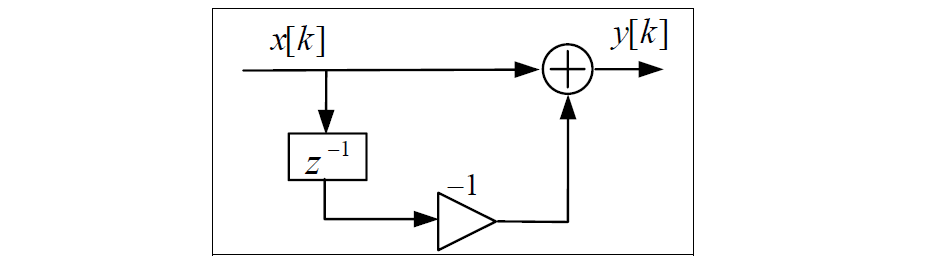

Блок $z^{-1}$ соответствует задержке на один такт дискретизации. 

Этот фильтр всегда устойчив.     
Если $x[k]=\mathbf{1}[k],$ то $y[k]=h[k].$ Поэтому импульсная характеристика простого дифференциатора имеет вид:
$$h[k]=\mathbf{1}[k]-\mathbf{1}[k-1].$$
Это пример КИХ-фильтра. Его частотная характеристика ($\theta=2\pi\nu$)
$$H\left( \theta  \right)=1-\exp (-j\theta )=2j\exp \left( -j\frac{\theta }{2} \right)\sin \left( \frac{\theta }{2} \right)$$
Амплитудно-частотная характеристика (АЧХ) простого дифференциатора
$$\left| H\left( \theta  \right) \right|=2\left| \sin \left( \frac{\theta }{2} \right) \right|$$
$$\left| H\left( \nu  \right) \right|=2\left| \sin \left( \pi \nu \right) \right|$$

### Вычисление частотной характеристики как ДВПФ $h[k]$

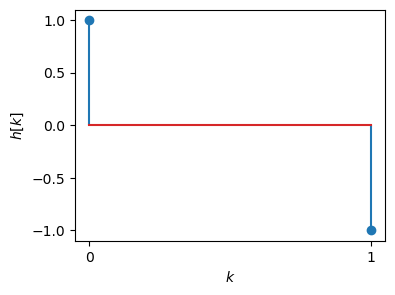

In [2]:
h=np.array([1.0, -1.0])
plt.figure(figsize=[4, 3])
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.stem(h)
plt.xlabel('$k$')
plt.ylabel('$h[k]$');

In [3]:
nu, H = dtft(h)

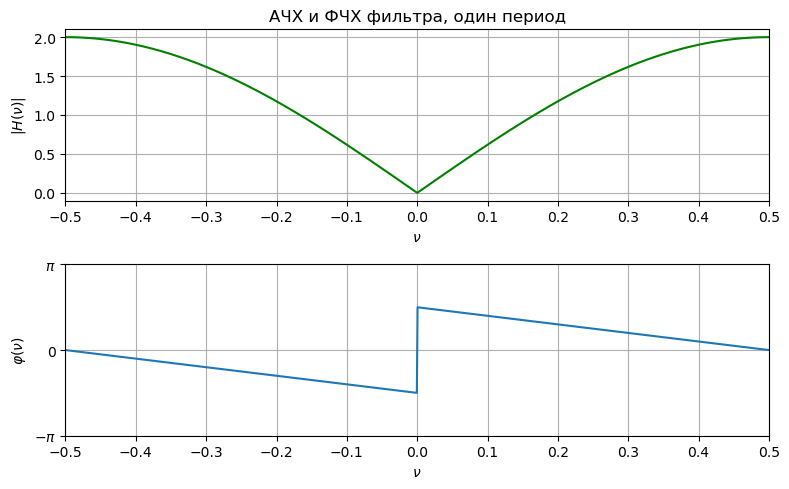

In [4]:
plt.figure(figsize=[8, 5])

plt.subplot(2, 1, 1)
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.title('АЧХ и ФЧХ фильтра, один период')
plt.plot(nu, abs(H), 'g')
plt.xlabel("$\\nu$")
plt.ylabel("$|H(\\nu)|$")
plt.grid()

plt.subplot(2, 1, 2)
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.plot(nu, np.angle(H))
plt.ylabel("$\\varphi(\\nu)$")
plt.xlabel("$\\nu$")
plt.yticks([-np.pi, 0, np.pi], labels=("$-\\pi$", "0", "$\\pi$"))
plt.grid()
plt.tight_layout()

In [5]:
nu3, H3 = np.hstack([nu-1, nu, nu+1]), np.hstack([H, H, H])

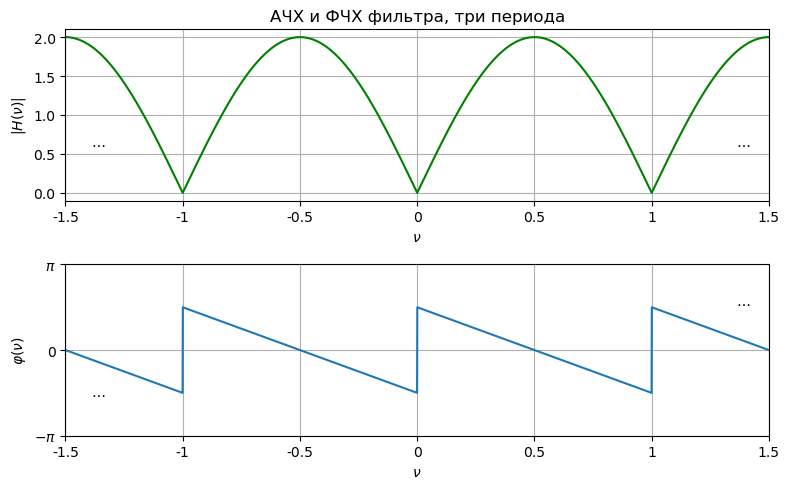

In [6]:


plt.figure(figsize=[8, 5])

plt.subplot(2, 1, 1)
plt.xlim([-1.5, 1.5])
plt.xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5],
          labels=('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.title('АЧХ и ФЧХ фильтра, три периода')
plt.plot(nu3, abs(H3), 'g')
plt.xlabel("$\\nu$")
plt.ylabel("$|H(\\nu)|$")
plt.grid()
plt.text(-1.4, 0.6, '$\dots$')
plt.text(1.35, 0.6, '$\dots$')
plt.subplot(2, 1, 2)
plt.xlim([-1.5, 1.5])
plt.plot(nu3, np.angle(H3))
plt.ylabel("$\\varphi(\\nu)$")
plt.xlabel("$\\nu$")
plt.yticks([-np.pi, 0, np.pi], labels=("$-\\pi$", "0", "$\\pi$"))
plt.text(-1.4, -np.pi/2-0.1, '$\dots$')
plt.text(1.35, np.pi/2+0.1, '$\dots$')
plt.grid()
plt.xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5],
          labels=('-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'))
plt.tight_layout()

### Вычисление отклика системы $y[k]$ при известном входном воздествии $x[k]$.

 #### 1 способ. Вычисление линейной дискретной свертки импульсной характеристики $h[k]$ с $x[k]$
 
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html
 
 Поскольку это КИХ-фильтр, то мы можем вычислить свертку 
 $$y[k]=\sum_{m=-\infty}^{\infty} x[m] h[k-m]$$.

In [7]:
x=np.ones(8)
h=np.array([1.0, -1.0])
y=signal.convolve(x, h)
y

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])

#### 2 способ. Вычисление по уравнению фильтра.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

Этот метод работает как для КИХ-фильтров, так и для БИХ-фильтров. 
Для физически реализуемой дискретной LTI–системы разностное уравнение может быть записано в виде 
$$\sum\limits_{m=0}^{M}{{{\alpha }_{m}}}y[k-m]=\sum\limits_{m=0}^{N-1}{{{\beta }_{m}}}x[k-m],$$
где $\alpha_m$ и $\beta_m$ – заданные коэффициенты, $M$ и $N$ – натуральные числа. Как правило, полагают ${{\alpha }_{0}}=1$, в таком случае разностное уравнение имеет вид
$$y[k]=\sum\limits_{m=0}^{N-1}{{{\beta }_{m}}}x[k-m]-\sum\limits_{m=1}^{M}{{{\alpha }_{m}}}y[k-m].$$
$$y[k]=x[k]-x[k-1],$$


`scipy.signal.lfilter(b, a, x, axis=- 1, zi=None)`
Filter data along one-dimension with an IIR or FIR filter.

Filter a data sequence, x, using a digital filter. This works for many fundamental data types (including Object type). The filter is a direct form II transposed implementation of the standard difference equation (see Notes).

**Parameters**

* `b` *array_like* The numerator coefficient vector in a 1-D sequence.

* `a` *array_like* The denominator coefficient vector in a 1-D sequence. If `a[0]` is not 1, then both a and b are normalized by `a[0]`.

* `x` *array_like* An N-dimensional input array.

* `axis` *int, optional* The axis of the input data array along which to apply the linear filter. The filter is applied to each subarray along this axis. Default is -1.

* `zi` *array_like, optional*
Initial conditions for the filter delays. It is a vector (or array of vectors for an N-dimensional input) of length `max(len(a), len(b)) - 1`. If `zi` is None or is not given then initial rest is assumed. See `lfiltic` for more information.

**Returns**
* `y` *array* The output of the digital filter.

* `zf` *array, optional* If `zi` is None, this is not returned, otherwise, `zf` holds the final filter delay values.

In [8]:
x = np.ones(8)
beta = np.array([1.0, -1.0])
alpha = np.array([1.0, 0.0])
y, zf = scipy.signal.lfilter(b=beta, a=alpha, x=x, zi=[0])
print('y = ', y)
print('zf = ', zf)

y =  [1. 0. 0. 0. 0. 0. 0. 0.]
zf =  [-1.]


In [9]:
y

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
x2=np.zeros(10)
x2[0:x.size]=x
print('x2 = ', x2)
beta = np.array([1.0, -1.0])
alpha = np.array([1.0, 0.0])
y, zf = scipy.signal.lfilter(b=beta, a=alpha, x=x2, zi=[0])
print('y = ', y)
print('zf = ', zf)

x2 =  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
y =  [ 1.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
zf =  [-0.]


## Пример. Дискретный накопитель (сумматор).

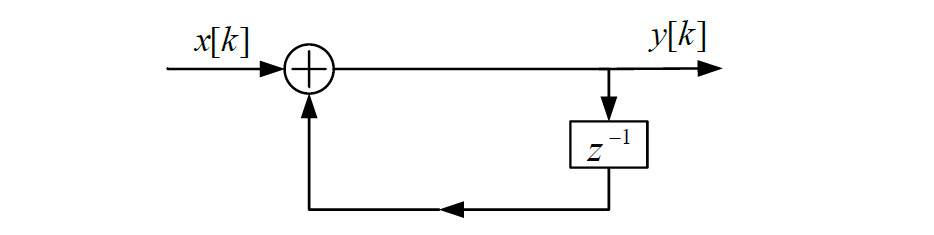

Рассмотрим фильтр 
$y[k]=Ay[k-1]+x[k],\text{  }y[-1]=0$
при $A=1$. В каком случае фильтр будет представлять собой рекурсивную реализацию сумматора:
$y[k]=y[k-1]+x[k],\text{  }y[-1]=0.$


Выходной сигнал в нем равен сумме отсчетов входного сигнала предшествующие моменты времени (при условии, что входной сигнал начинает действовать в нулевой момент времени). Импульсная характеристика такой системы
$$h[k]=u[k]=\left\{ \begin{matrix}
   1, k\ge 0,  \\
   0, k<0,  \\
\end{matrix} \right.$$
не является абcолютно суммируемой, и фильтр неустойчив.



$$y[k]=\sum\limits_{m=0}^{N-1}{{{\beta }_{m}}}x[k-m]-\sum\limits_{m=1}^{M}{{{\alpha }_{m}}}y[k-m].$$


In [11]:
beta = np.array([1.0, 0])
alpha = np.array([1.0, -1.0])

In [12]:
x1=np.array([1, 2, 3, 4, 0, 0])
y, zf =scipy.signal.lfilter(b=beta, a=alpha, x=x1, zi=[0])
print('y = ', y)
print('zf = ', zf)

y =  [ 1.  3.  6. 10. 10. 10.]
zf =  [10.]


## Пример. Фильтр скользящего среднего.

$$y[k]=\dfrac{1}{M}\sum_{m=0}^{M-1} x[k-m]$$


* Определите  импульсную характеристику $h[k]$ фильтра.

По опредлению, импульсная характеристика является реакцией на единичный импульс
Если $x[k]=\mathbf{1} [k]$, то $y[k]=\dfrac{1}{M}\sum_{m=0}^{M-1} \mathbf{1} [k-m]$. Тогда 

$$h[k]=\dfrac{1}{M}\sum_{m=0}^{M-1} \mathbf{1} [k-m]$$

In [13]:
M=10
h=np.ones(M)/M

N=100
k=np.arange(N)
x=np.sin(2*np.pi*0.02*k)+np.random.normal(0, 0.1, N)
y=signal.convolve(x, h)

C:\Users\torma\AppData\Local\Temp\ipykernel_14320\3239650067.py:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(k, x, use_line_collection=True)
C:\Users\torma\AppData\Local\Temp\ipykernel_14320\3239650067.py:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(y.size), y, use_line_collection=True)


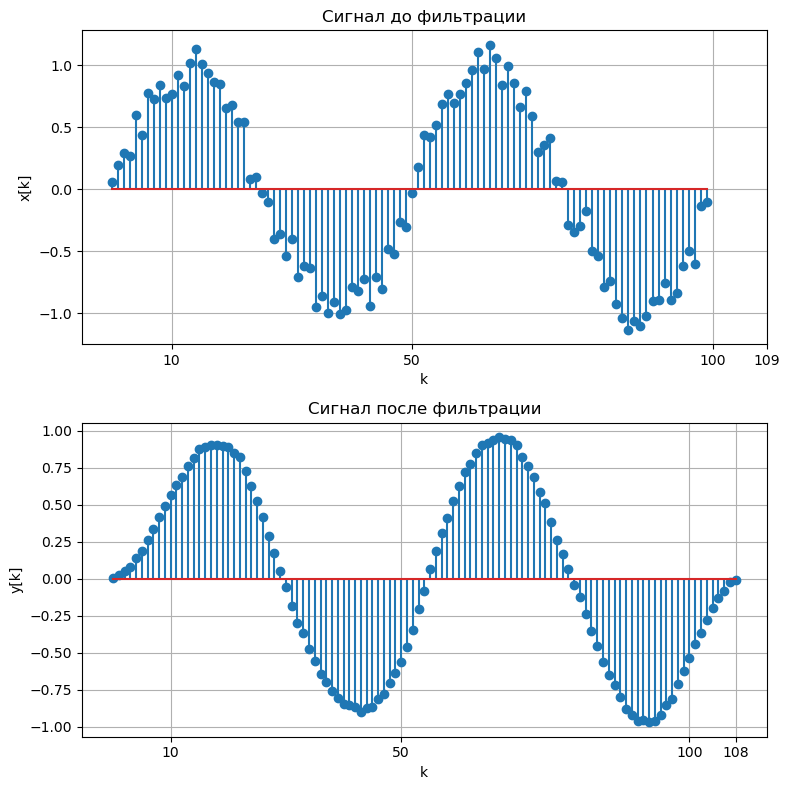

In [14]:
plt.figure(figsize=[8, 8], dpi=100)
plt.subplot(2, 1, 1)
plt.title("Сигнал до фильтрации")
plt.stem(k, x, use_line_collection=True)
plt.xticks([M, N/2, N, M+N-1])
plt.grid()
plt.ylabel("x[k]")
plt.xlabel("k")

plt.subplot(2, 1, 2)
plt.title("Сигнал после фильтрации")
plt.stem(np.arange(y.size), y, use_line_collection=True)
plt.xticks([M, N/2, N, M+N-2])
plt.ylabel("y[k]")
plt.xlabel("k")
plt.grid()
plt.tight_layout()

In [15]:
M=10
h=np.ones(M)/M
def dtft(x, M=2048):
    return np.arange(M)/M-0.5, np.fft.fftshift(np.fft.fft(x, M))

In [16]:
nu, H = dtft(h)

In [17]:
nu3, H3 = np.hstack([nu-1, nu, nu+1]), np.hstack([H, H, H])

In [18]:
# %matplotlib notebook

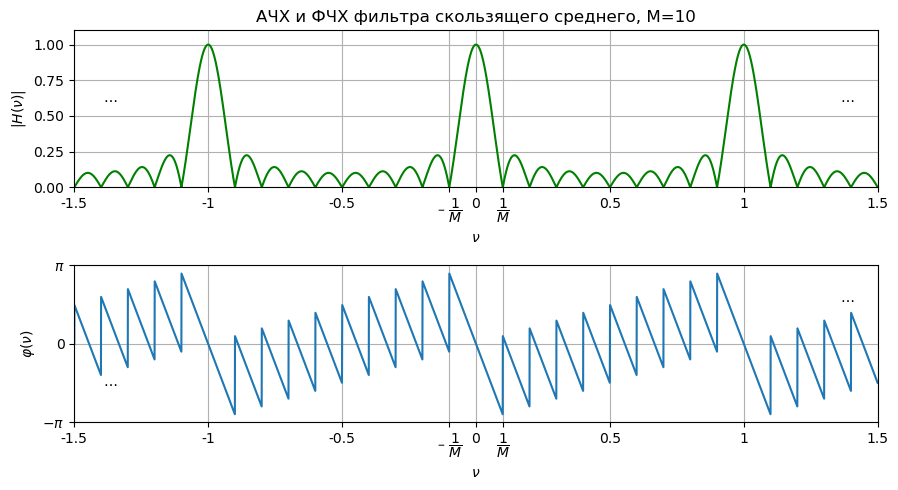

In [19]:
plt.figure(figsize=[9, 5])

plt.subplot(2, 1, 1)
plt.ylim([0, 1.1])
plt.xlim([-1.5, 1.5])
plt.xticks([-1.5, -1, -0.5, -1.0/M, 0, 1.0/M, 0.5, 1, 1.5],
          labels=('-1.5', '-1', '-0.5', '– $\\dfrac{1}{M}$', '0', 
                  '$\\dfrac{1}{M}$', '0.5', '1', '1.5'))
plt.title('АЧХ и ФЧХ фильтра скользящего среднего, M=%i' %M)
plt.plot(nu3, abs(H3), 'g')
plt.xlabel("$\\nu$")
plt.ylabel("$|H(\\nu)|$")
plt.grid()
plt.text(-1.4, 0.6, '$\dots$')
plt.text(1.35, 0.6, '$\dots$')
plt.subplot(2, 1, 2)
plt.xlim([-1.5, 1.5])
plt.plot(nu3, np.angle(H3))
plt.ylabel("$\\varphi(\\nu)$")
plt.xlabel("$\\nu$")
plt.yticks([-np.pi, 0, np.pi], labels=("$-\\pi$", "0", "$\\pi$"))
plt.text(-1.4, -np.pi/2-0.1, '$\dots$')
plt.text(1.35, np.pi/2+0.1, '$\dots$')
plt.grid()
plt.xticks([-1.5, -1, -0.5, -1.0/M, 0, 1.0/M, 0.5, 1, 1.5],
          labels=('-1.5', '-1', '-0.5', '– $\\dfrac{1}{M}$', '0', 
                  '$\\dfrac{1}{M}$', '0.5', '1', '1.5'))
plt.tight_layout()

##  КИХ-фильтр эффекта эхо 

Разностное уравнение цифрового фильтра 
$$y[k]=\dfrac{ax[k]+bx[k-N]+cx[k-2N]}{a+b+c}$$

$$y[k]=Ax[k]+Bx[k-N]+Cx[k-2N]$$

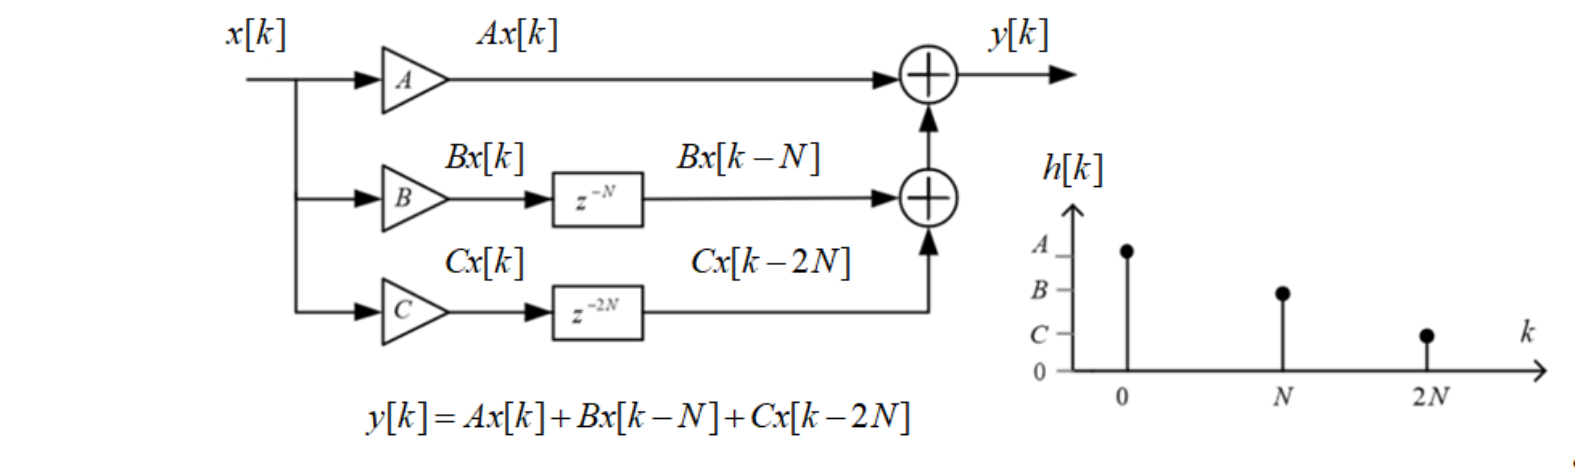

In [20]:
import scipy.io.wavfile
from IPython.display import Audio
Audio('./hello0.wav')

In [21]:
fs, x1=scipy.io.wavfile.read('./hello0.wav')

In [22]:
x1[-44000:-1]

array([259, 245, 201, ...,   1,  -2,   0], dtype=int16)

In [23]:
x1.size

23183

In [24]:
N=int(23183*0.7)
a=1
b=0.5
c=0.2

A=a/(a+b+c)
B=b/(a+b+c)
C=c/(a+b+c)

h=np.zeros(3*N)
h[0]=A
h[N]=B
h[2*N]=C

In [25]:
fs, x1=scipy.io.wavfile.read('./hello0.wav')

In [26]:
y=signal.convolve(x1, h)
y=np.array(y, dtype=np.int16)

In [27]:
scipy.io.wavfile.write(filename='./hello2.wav', rate=fs, data=y)

In [28]:
Audio('./hello2.wav')

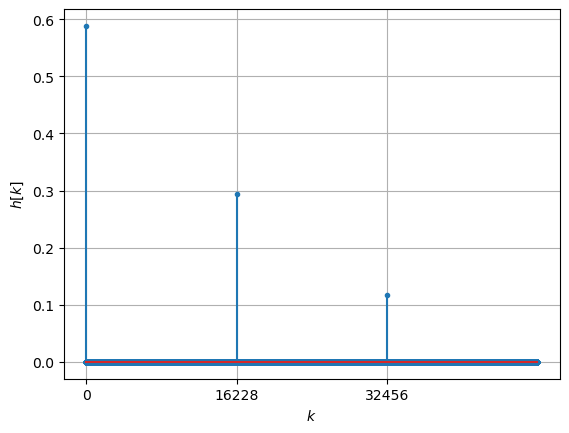

In [43]:
plt.figure()
plt.stem(h, markerfmt='.')
plt.xticks([0, N, 2*N])
plt.xlabel("$k$")
plt.ylabel("$h[k]$")
plt.grid()
plt.show()

## БИХ-фильтр эффекта эхо 

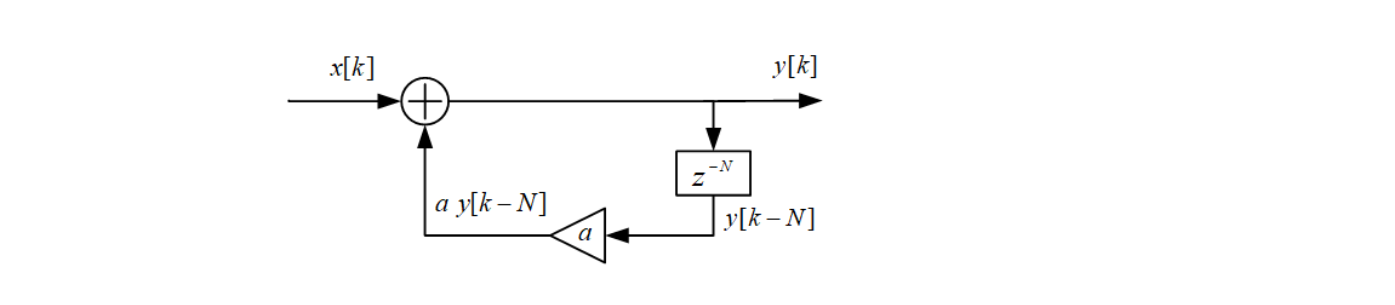

$$y[k]=\alpha y[k-N] + x[k]$$

$$y[k]-\alpha y[k-N] = x[k]$$

$$a_0 y[k] + a_N y[k-N] = b_0 x[k]$$

In [30]:
b=np.array([1])
N=int(23183*0.7)
alpha=0.5
a=np.zeros(N+1)
a[0]=1
a[N]=-alpha

In [31]:
b

array([1])

In [32]:
a

array([ 1. ,  0. ,  0. , ...,  0. ,  0. , -0.5])

In [33]:
fs, x1=scipy.io.wavfile.read('./hello0.wav')
x1=np.hstack([x1, np.zeros(x1.size*6)])

In [34]:
y=scipy.signal.lfilter(b, a, x=x1)
y=np.array(y, dtype=np.int16)

In [35]:
scipy.io.wavfile.write(filename='./hello3.wav', rate=fs, data=y)
Audio('./hello3.wav')